# Set-up

## Imports

In [1]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 200
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, f1_score, classification_report, matthews_corrcoef, PrecisionRecallDisplay
import joblib
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# ALE
from alibi.explainers import ALE, plot_ale

## Parameters

In [19]:
scope = 'OFF'
input_path = f'../data/3_output/ML_dataset_{scope}.pkl'

train_years = [2021]
test_years = [2022]

subsample_frac = 0.1

target = 'Result'

features_to_encode = [
    'MargTech',
    'WorkDay',
    'Prov',
    'Tech',
]

other_features = [
    'hour',
    'SC_PC1',
    'SC_PC2',
    'IN_PC1',
    'IN_PC2',
    'CT_PC1',
    'CT_PC2',
    'PurchMGP',
    'SellMGP',
    'SolarAngle',
    'DeclAngle',
    'PVnew',
    'PriceDiff',
]

features = other_features + features_to_encode

# Main

## Load data

In [20]:
input_df = pd.read_pickle(input_path)
print("{:,}".format(len(input_df)))
input_df.head(3)

3,574,411


,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,-178.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.0,0.0,111.74,0.419,False
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,-163.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.0,0.0,111.74,0.433,False
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,...,-148.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.0,0.0,111.74,0.451,False


In [21]:
# Subsample
if subsample_frac is not None:
    print(f'Subsampled {100*subsample_frac:.0f}% rows from the input dataset')
    df = input_df.sample(frac=subsample_frac)
else:
    df = input_df.copy()

print('Input dataset is composed of {:,} observations'.format(len(input_df)))
print('{:.1%} bids accepted in the input dataset\n'.format(input_df[target].sum() / len(input_df)))

train_df = df[df.year.isin(train_years)]
print('Training data is composed of {:,} observations and correspond to years {}'.format(len(train_df), ' '.join([str(year) for year in train_years])))
print('{:.1%} bids accepted in the training data\n'.format(train_df[target].sum() / len(train_df)))

test_df = df[df.year.isin(test_years)]
# test_df.dropna(subset=['PriceDiff'], inplace=True) # HOTFIX
# test_df = test_df[~(test_df == np.inf).any(axis=1)] # HOTFIX
print('Test data is composed of {:,} observations and correspond to years {}'.format(len(test_df), ' '.join([str(year) for year in test_years])))
print('{:.1%} bids accepted in the test data'.format(test_df[target].sum() / len(test_df)))

Subsampled 10% rows from the input dataset
Input dataset is composed of 3,574,411 observations
3.6% bids accepted in the input dataset

Training data is composed of 67,187 observations and correspond to years 2021
3.8% bids accepted in the training data

Test data is composed of 61,323 observations and correspond to years 2022
3.5% bids accepted in the test data


In [22]:
# We take of the fact that some categories could be absent in the training set but present in the test set
categories = [input_df[feature].unique() for feature in features_to_encode]

feature_transformer = make_column_transformer(
    (OneHotEncoder(categories=categories), features_to_encode),
    remainder="passthrough",
    verbose_feature_names_out=False
)

X_train = feature_transformer.fit_transform(train_df[features])
y_train = train_df[target]

X_test = feature_transformer.transform(test_df[features])
y_test = test_df[target]

print('Input features are:')
print(feature_transformer.feature_names_in_)

Input features are:
['hour' 'SC_PC1' 'SC_PC2' 'IN_PC1' 'IN_PC2' 'CT_PC1' 'CT_PC2' 'PurchMGP'
 'SellMGP' 'SolarAngle' 'DeclAngle' 'PVnew' 'PriceDiff' 'MargTech'
 'WorkDay' 'Prov' 'Tech']


## Load model

In [23]:
model_path = '{}/model_dumps/model_trained_{}_{}.joblib'.format(scope, scope, '_'.join([str(year) for year in train_years]))
clf = joblib.load(model_path)
print(f'Model {model_path} loaded\n')

Model OFF/model_dumps/model_trained_OFF_2021.joblib loaded



## Permutation Feature Importance

In [24]:
clf_pipeline = make_pipeline(feature_transformer, clf)

In [25]:
train_result = permutation_importance(
    clf_pipeline, train_df[features], y_train, scoring='average_precision', random_state=42, n_jobs=-1
)

In [26]:

test_result = permutation_importance(
    clf_pipeline, test_df[features], y_test, scoring='average_precision', random_state=42, n_jobs=-1
)

/Users/guillaume/prometheus/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [27]:
sorted_importances_idx = train_result.importances_mean.argsort()

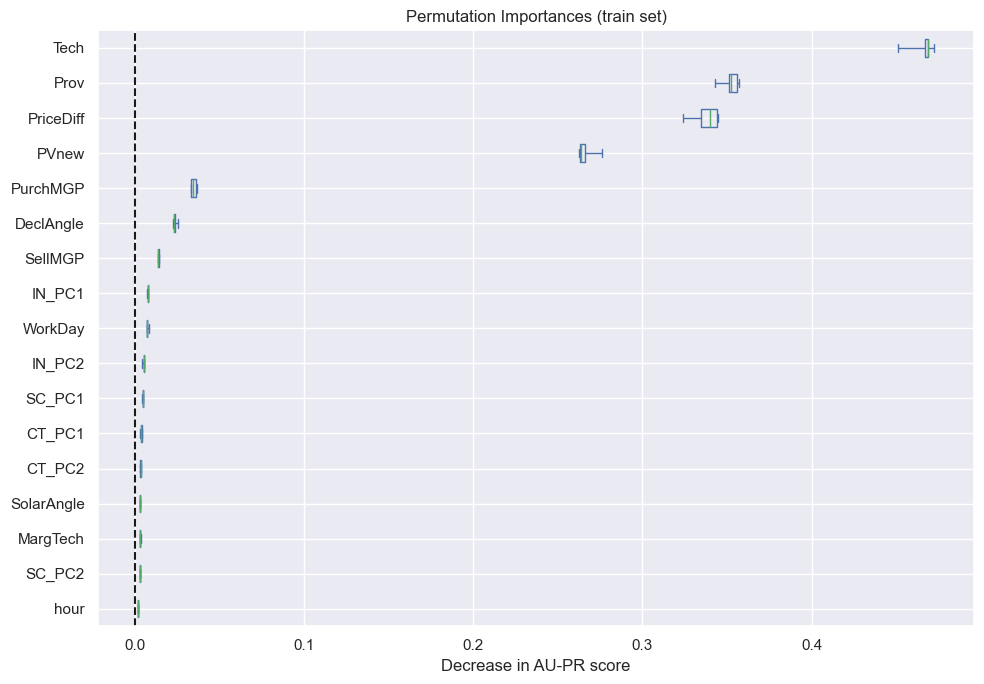

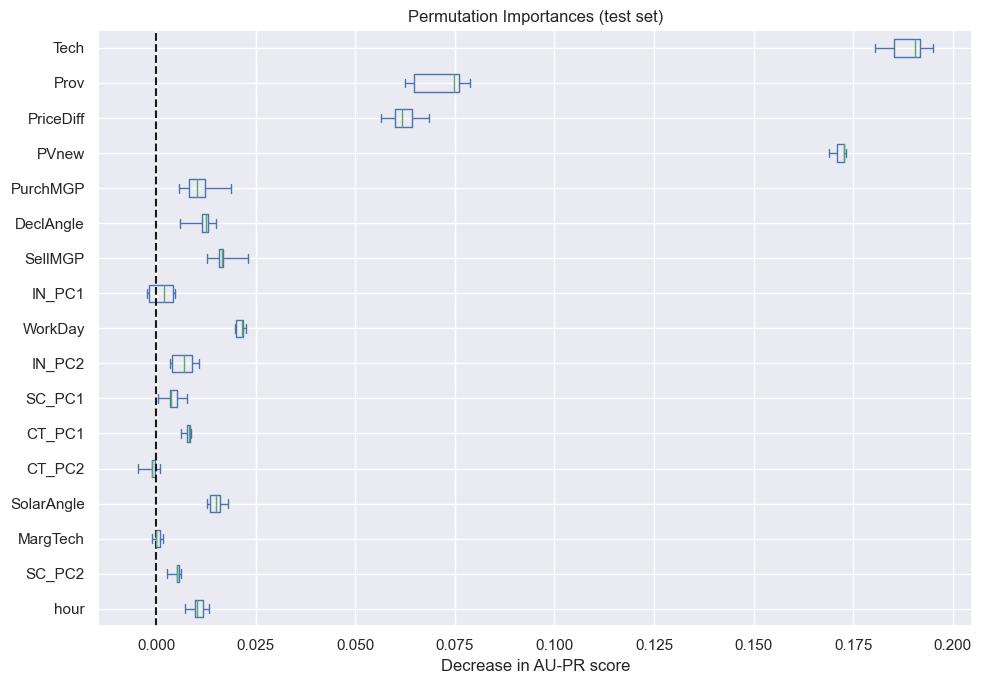

In [28]:
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=train_df[features].columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_result.importances[sorted_importances_idx].T,
    columns=train_df[features].columns[sorted_importances_idx],
)

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
# for name, importances in zip(["train"], [train_importances]):
    ax = importances.plot.box(vert=False, whis=10, figsize=(10,7))
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in AU-PR score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

In [34]:
test_importances

,hour,SC_PC2,MargTech,SolarAngle,CT_PC2,CT_PC1,SC_PC1,IN_PC2,WorkDay,IN_PC1,SellMGP,DeclAngle,PurchMGP,PVnew,PriceDiff,Prov,Tech
0,0.010258,0.005209,-0.000920,0.013427,0.000976,0.008597,0.007780,0.007030,0.020098,0.001909,0.016718,0.015152,0.012296,0.172784,0.059899,0.074700,0.194955
1,0.011882,0.006254,0.001677,0.016142,-0.004575,0.008391,0.000591,0.003996,0.019840,0.004187,0.016584,0.013148,0.010203,0.168926,0.061656,0.062424,0.185277
2,0.009817,0.005720,0.000873,0.015142,-0.000310,0.007858,0.003739,0.003521,0.022568,0.004737,0.022965,0.006063,0.018699,0.172805,0.068590,0.064735,0.180406
3,0.013352,0.002814,-0.000124,0.018029,-0.000980,0.006291,0.003434,0.010717,0.021789,-0.002149,0.012830,0.012560,0.005802,0.173130,0.064209,0.076047,0.191886
4,0.007364,0.005224,0.000016,0.012843,-0.001091,0.008677,0.005347,0.009044,0.021683,-0.001664,0.015894,0.011603,0.008179,0.170986,0.056543,0.078852,0.190574


## Partial Dependence Plot

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_24345/2548943440.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  disp.figure_.axes[1].set_xticklabels(xtick_names)


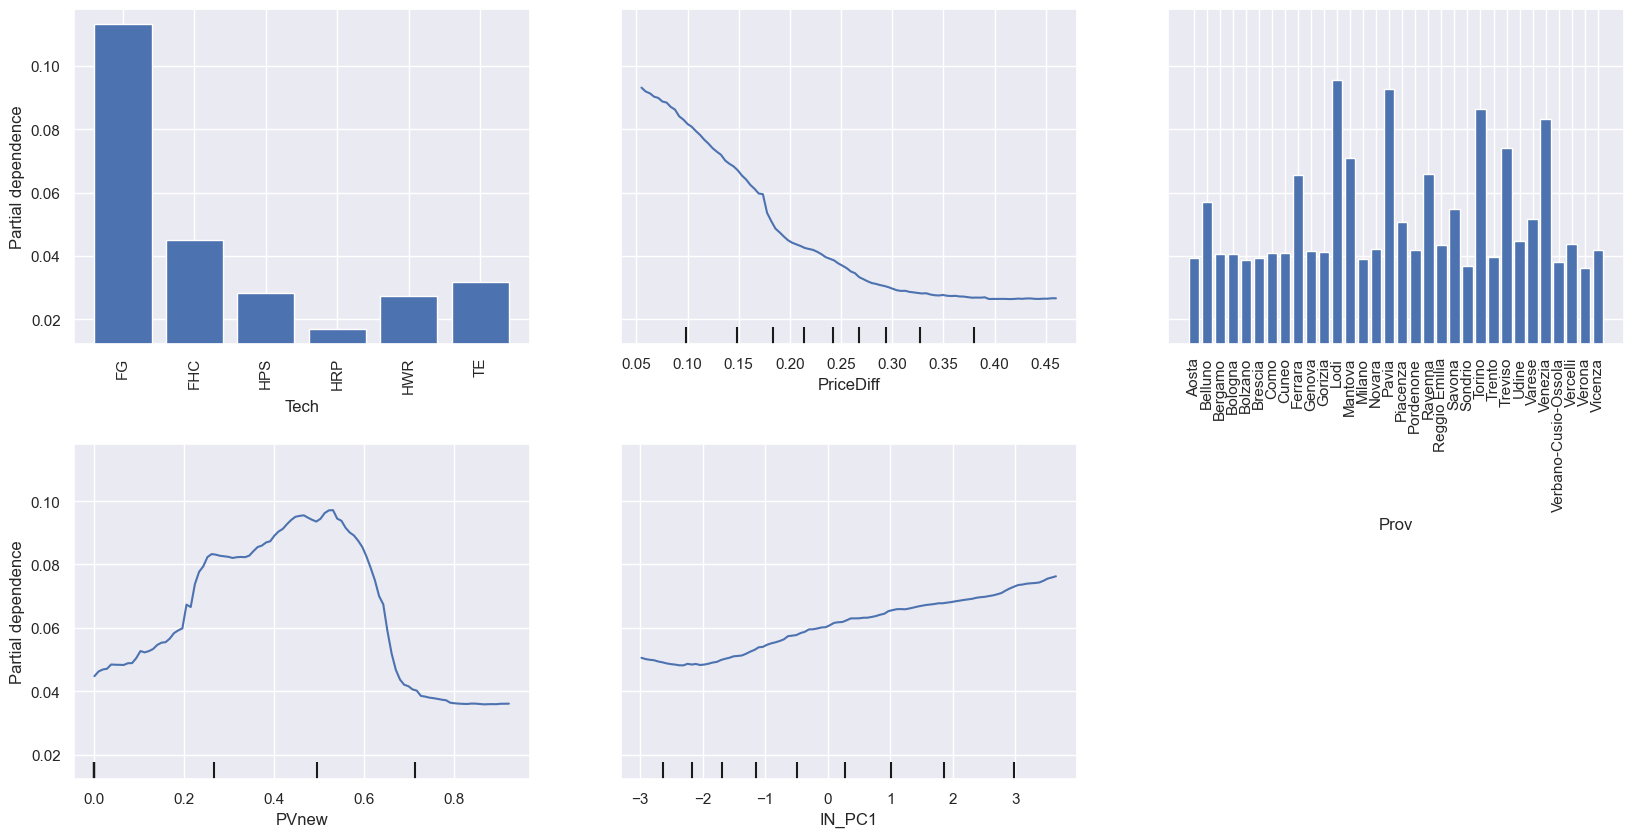

In [30]:
disp = PartialDependenceDisplay.from_estimator(
    clf_pipeline,
    X = test_df[features],
    features = ['Tech', 'PriceDiff', 'Prov', 'PVnew', 'IN_PC1'],
    categorical_features = np.array([col in features_to_encode for col in test_df[features].columns.to_list()]),
    n_jobs = -1,
    kind = ['average', 'average', 'average', 'average', 'average'],
    subsample = 100,
)

xtick_names = ['FG', 'FHC', 'HPS', 'HRP', 'HWR', 'TE']
disp.figure_.axes[1].set_xticklabels(xtick_names)
disp.figure_.set_size_inches(20, 10)
disp.figure_.subplots_adjust(hspace=0.3)

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_24345/554601042.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  disp.figure_.axes[1].set_xticklabels(xtick_names)


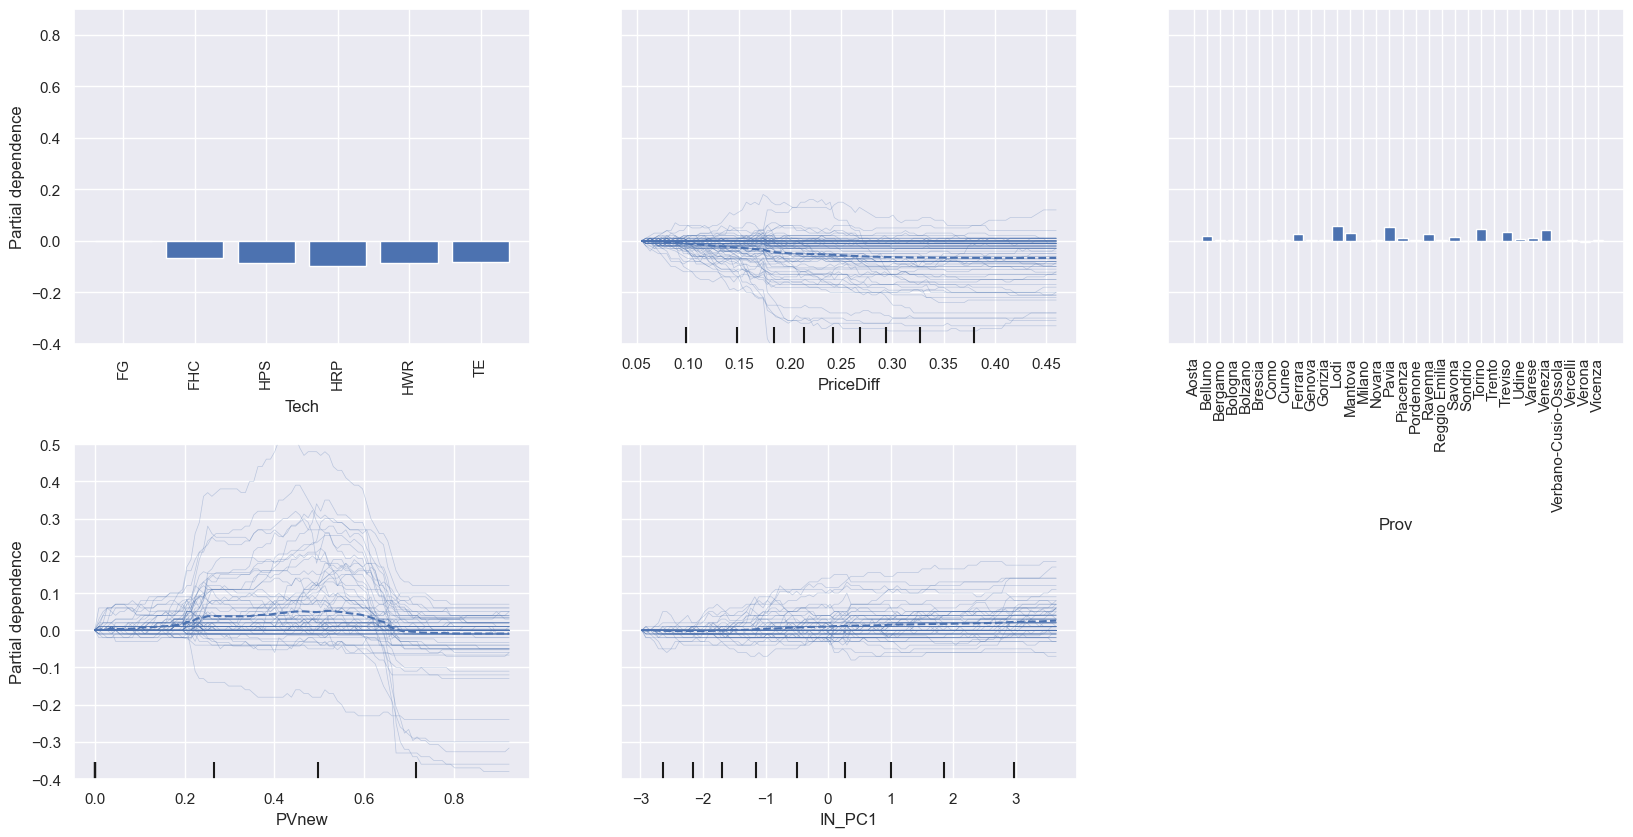

In [31]:
disp = PartialDependenceDisplay.from_estimator(
    clf_pipeline,
    X = test_df[features],
    features = ['Tech', 'PriceDiff', 'Prov', 'PVnew', 'IN_PC1'],
    categorical_features = np.array([col in features_to_encode for col in test_df[features].columns.to_list()]),
    n_jobs = -1,
    kind = ['average', 'both', 'average', 'both', 'both'],
    subsample = 100,
    centered=True
)

# Display settings for OFF
# for ax in disp.figure_.axes:
#     ax.set_ylim(-.7,.3)
#     if ax.get_xlabel() in ['PVold', 'Prov']:
#         ax.set_ylim(-.2,.8)

# Display settings for BID
for ax in disp.figure_.axes:
    ax.set_ylim(-.4,.9)
    if ax.get_xlabel() in ['PVnew', 'IN_PC1']:
        ax.set_ylim(-.4,.5)
xtick_names = ['FG', 'FHC', 'HPS', 'HRP', 'HWR', 'TE']
disp.figure_.axes[1].set_xticklabels(xtick_names)
disp.figure_.set_size_inches(20, 10)
disp.figure_.subplots_adjust(hspace=0.3)

## Accumulated Local Effects (ALE)

In [32]:
predictor = clf.predict_proba

# Features to explain should be numerical or ordinal
encoded_feature_names = list(feature_transformer.get_feature_names_out())
features_to_explain = [encoded_feature_names.index(feature) for feature in ['PVnew', 'PriceDiff', 'IN_PC1']]

ale = ALE(predictor, encoded_feature_names, target_names=['Rejected', 'Accepted'])
ale = ale.explain(X_test.toarray(), features=features_to_explain)

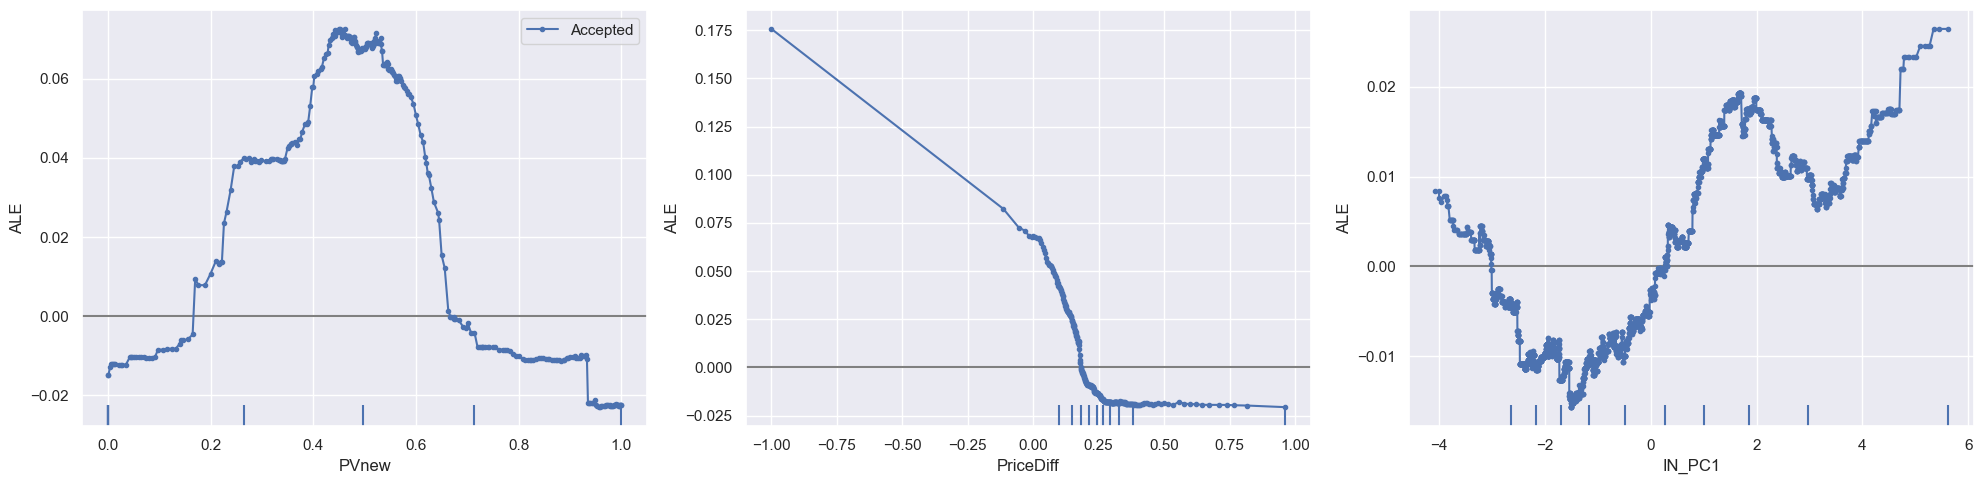

In [33]:
plot_ale(ale, targets=['Accepted'], n_cols=4, fig_kw={'figwidth': 20, 'figheight': 5}, sharey=None)
plt.tight_layout()